## Домашка 1
#### *«Великаны — как луковицы. Лук многослоен! Я тоже! Слой за слоем. Ты усёк? Мы многослойные!» — Шрек*

Эта домашка про декомпозицию и срезы. За неё можно получить максимум 6 баллов. На решение отводится **14 календарных дней** с момента выдачи. Обратите внимание, что **дедлайны на курсе сразу жёсткие**, а значит отправка решений после них запрещена.
Задание выполняется самостоятельно, списывания не допускаются. При обнаружении одинаковых работ балл за задание анулируется у всех студентов, вне зависимости от того, кто у кого списал.

#### **Как сдать домашку?**
1. Скачайте этот ноутбук.
2. Решите задания (локально или в Google Colab). 
3. Опубликуйте решенный ноутбук в свой GitHub репозиторий (проверьте, чтобы он был публичным).
4. Приложите ссылку на решение в Яндекс-Форму для сдачи ДЗ (будет доступна на LMS Karpov Courses и в Телеграм-канале курса).

**Внимание**: Если вы работаете в Google Colab, также скачивайте .ipynb файл и публикуйте его в репозитории. Ссылки на Colab к сдаче не принимаются.


Все датасеты, с которыми предлагается работать в домашних заданиях, взяты из открытых источников или сгенерированы. Любые паттерны, найденные вне заданной канвы решения, являются случайными и не несут в себе смысла или инсайта.

[Данные](https://github.com/brezhnevaan/hse_product_metrics_course/releases/download/datasets_for_hw/hw_1_data.zip)

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

### Case Study. Что-то пошло не так в маркетплейсе 🛒

**Легенда**  
Вы работаете продуктовым аналитиком в маркетплейсе. Ваша команда отвечает за функционал корзины — точки входа, дизайн и функционал самой корзины, путь пользователя с момента добавления товара в корзину и до оформления покупки. 

Компания — стартап без системы автоматического мониторинга. Поэтому последние 14 дней, пока вы были в отпуске, никто не следил за метриками корзины. 

Вы отлично отдохнули и в первый же день после каникул рвётесь в бой. Наливаете чашку кофе, открываете ноутбук и проверяете, что творилось в ваше отсутствие.

In [4]:
df = pd.read_parquet('hw_1_marketplace_data.parquet')

In [5]:
df.head()

,user_id,session_id,event_ts,platform,app_version,region,channel,category,event,product_id,price,quantity
0,30,1094418511,2025-04-01 19:49:57,Desktop,web,siberia,ads_search,None,search,NaN,NaN,NaN
1,30,1094418511,2025-04-01 20:02:23,Desktop,web,siberia,ads_search,electronics,view_item,123443.0,NaN,NaN
2,30,1094418511,2025-04-01 20:22:53,Desktop,web,siberia,ads_search,fashion,view_item,162950.0,NaN,NaN
3,30,1094418511,2025-04-01 20:40:57,Desktop,web,siberia,ads_search,home,view_item,199979.0,NaN,NaN
4,30,1094418511,2025-04-01 20:41:07,Desktop,web,siberia,ads_search,home,add_to_cart,199979.0,NaN,NaN


Описание данных

- user_id — уникальный идентификатор пользователя
- session_id — уникальный идентификатор сессии
- event_ts — таймстемп событий
- platform — платформа, с которой пришло событие
- app_version — версия приложения (существует только для iOS и Android, для остальных платформ приходят значения-заглушки)
- region — регион пользователя
- channel — канал, с которого пришел пользователь
- category — категория товаров, которой принадлежит ивент
- event — событие, совершенное пользователем
- product_id — идентификатор товара для событий над товарами
- price — цена товара, ивент приходит только для события покупки
- quantity — количество товаров, ивент приходит только для события покупки

#### **1. Детекция проблемы — 1 балл**

1) Посчитайте подневные конверсии: из просмотра в покупку, из просмотра в добавление в корзину, из добавления в корзину — в покупку.
2) Визуализируйте полученную динамику. 
3) Опишите, что вы видите на графике: когда и в каких метриках началось падение? есть ли устойчивый тренд?

*К подсчёту конверсий можно подойти разными способами — считать их по событиям, сессиям или уникальным юзерам. В нашей задаче будем считать по сессиям.*

In [6]:
# your code is here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Преобразуем event_ts в datetime
df['event_ts'] = pd.to_datetime(df['event_ts'])
df['date'] = df['event_ts'].dt.date

# Функция для расчета конверсий по сессиям
def calculate_daily_conversions(df):
    daily_metrics = []
    
    for date in df['date'].unique():
        day_data = df[df['date'] == date]
        
        # Уникальные сессии с просмотрами
        sessions_with_view = day_data[day_data['event'] == 'view_item']['session_id'].nunique()
        
        # Уникальные сессии с добавлением в корзину
        sessions_with_add_to_cart = day_data[day_data['event'] == 'add_to_cart']['session_id'].nunique()
        
        # Уникальные сессии с покупками
        sessions_with_purchase = day_data[day_data['event'] == 'purchase']['session_id'].nunique()
        
        # Рассчитываем конверсии
        view_to_purchase = (sessions_with_purchase / sessions_with_view * 100) if sessions_with_view > 0 else 0
        view_to_cart = (sessions_with_add_to_cart / sessions_with_view * 100) if sessions_with_view > 0 else 0
        cart_to_purchase = (sessions_with_purchase / sessions_with_add_to_cart * 100) if sessions_with_add_to_cart > 0 else 0
        
        daily_metrics.append({
            'date': date,
            'sessions_with_view': sessions_with_view,
            'sessions_with_add_to_cart': sessions_with_add_to_cart,
            'sessions_with_purchase': sessions_with_purchase,
            'view_to_purchase': view_to_purchase,
            'view_to_cart': view_to_cart,
            'cart_to_purchase': cart_to_purchase
        })
    
    return pd.DataFrame(daily_metrics)

# Рассчитываем ежедневные конверсии
daily_conversions = calculate_daily_conversions(df)

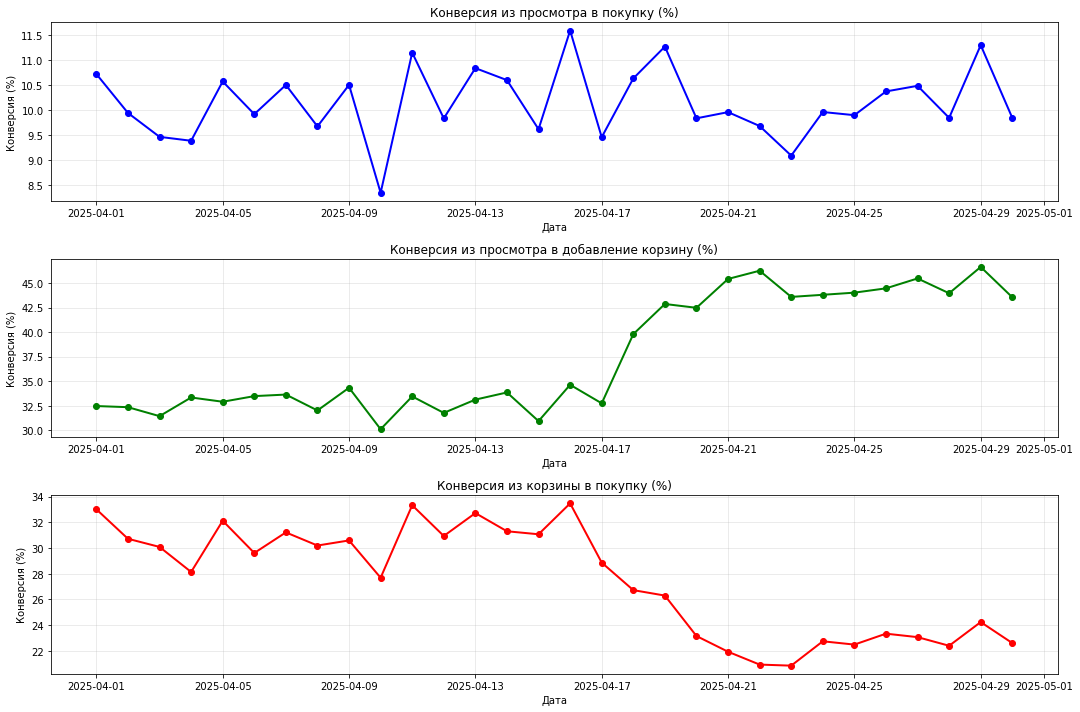

Анализ динамики конверсий:
Средняя конверсия просмотр → покупка: 10.14%
Средняя конверсия просмотр → корзина: 37.63%
Средняя конверсия корзина → покупка: 27.53%


In [7]:
# Визуализация
plt.figure(figsize=(15, 10))

# График конверсии из просмотра в покупку
plt.subplot(3, 1, 1)
plt.plot(daily_conversions['date'], daily_conversions['view_to_purchase'], 
         marker='o', linewidth=2, color='blue')
plt.title('Конверсия из просмотра в покупку (%)')
plt.xlabel('Дата')
plt.ylabel('Конверсия (%)')
plt.grid(True, alpha=0.3)

# График конверсии из просмотра в корзину
plt.subplot(3, 1, 2)
plt.plot(daily_conversions['date'], daily_conversions['view_to_cart'], 
         marker='o', linewidth=2, color='green')
plt.title('Конверсия из просмотра в добавление корзину (%)')
plt.xlabel('Дата')
plt.ylabel('Конверсия (%)')
plt.grid(True, alpha=0.3)

# График конверсии из корзины в покупку
plt.subplot(3, 1, 3)
plt.plot(daily_conversions['date'], daily_conversions['cart_to_purchase'], 
         marker='o', linewidth=2, color='red')
plt.title('Конверсия из корзины в покупку (%)')
plt.xlabel('Дата')
plt.ylabel('Конверсия (%)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ трендов
print("Анализ динамики конверсий:")
print(f"Средняя конверсия просмотр → покупка: {daily_conversions['view_to_purchase'].mean():.2f}%")
print(f"Средняя конверсия просмотр → корзина: {daily_conversions['view_to_cart'].mean():.2f}%")
print(f"Средняя конверсия корзина → покупка: {daily_conversions['cart_to_purchase'].mean():.2f}%")

#### **2. Проверка абсолютных и средних значений — 1 балл**

1) Постройте графики дневной динамики абсолютных значений, из которых рассчитаны конверсии выше.
2) Рассчитайте и визуализируйте среднее число событий (именно событий, не сессий), из которых рассчитаны конверсии, на пользователя. 
3) На каком этапе воронки появилась проблема?

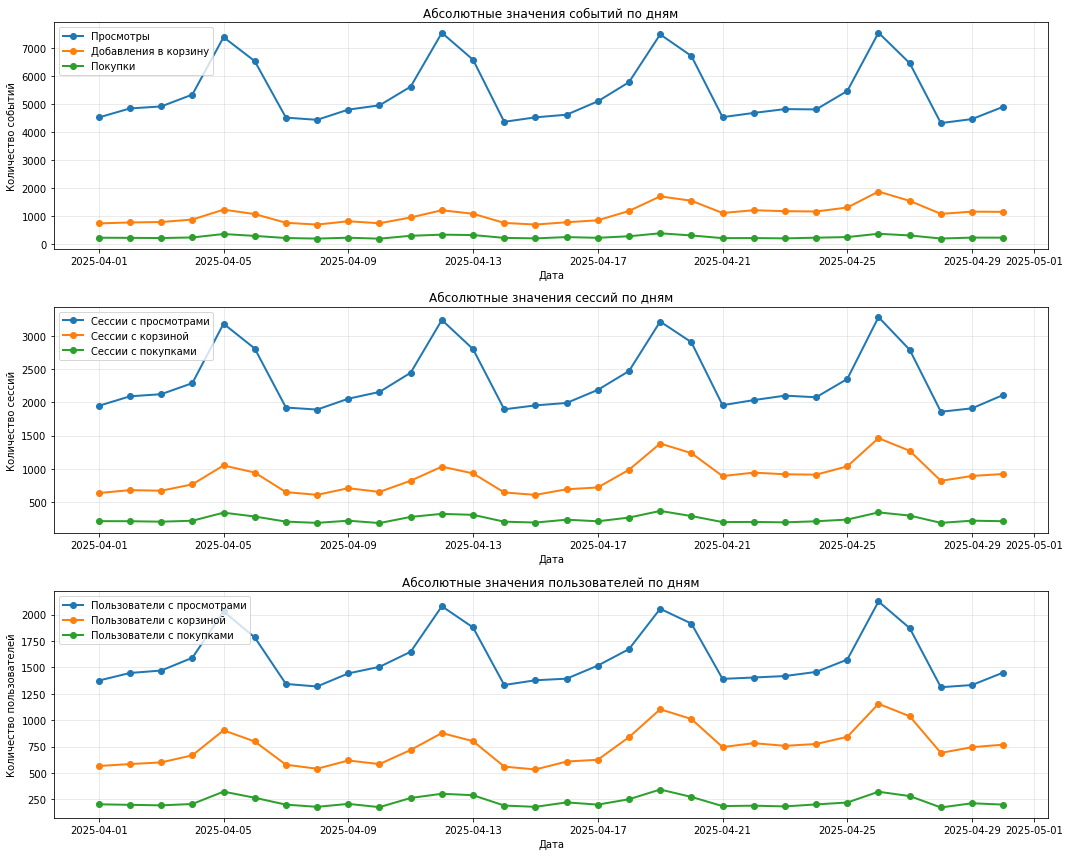

In [10]:
# your code is here

# Преобразуем event_ts в datetime
df['event_ts'] = pd.to_datetime(df['event_ts'])
df['date'] = df['event_ts'].dt.date

# 1. Графики дневной динамики абсолютных значений
def calculate_daily_absolute_metrics(df):
    daily_metrics = []
    
    for date in df['date'].unique():
        day_data = df[df['date'] == date]
        
        # Абсолютные значения по событиям
        views = len(day_data[day_data['event'] == 'view_item'])
        add_to_cart = len(day_data[day_data['event'] == 'add_to_cart'])
        purchases = len(day_data[day_data['event'] == 'purchase'])
        
        # Абсолютные значения по сессиям
        sessions_view = day_data[day_data['event'] == 'view_item']['session_id'].nunique()
        sessions_cart = day_data[day_data['event'] == 'add_to_cart']['session_id'].nunique()
        sessions_purchase = day_data[day_data['event'] == 'purchase']['session_id'].nunique()
        
        # Уникальные пользователи
        users_total = day_data['user_id'].nunique()
        users_view = day_data[day_data['event'] == 'view_item']['user_id'].nunique()
        users_cart = day_data[day_data['event'] == 'add_to_cart']['user_id'].nunique()
        users_purchase = day_data[day_data['event'] == 'purchase']['user_id'].nunique()
        
        daily_metrics.append({
            'date': date,
            'views': views,
            'add_to_cart': add_to_cart,
            'purchases': purchases,
            'sessions_view': sessions_view,
            'sessions_cart': sessions_cart,
            'sessions_purchase': sessions_purchase,
            'users_total': users_total,
            'users_view': users_view,
            'users_cart': users_cart,
            'users_purchase': users_purchase
        })
    
    return pd.DataFrame(daily_metrics)

daily_absolute = calculate_daily_absolute_metrics(df)

# Визуализация абсолютных значений
plt.figure(figsize=(15, 12))

# Абсолютные значения событий
plt.subplot(3, 1, 1)
plt.plot(daily_absolute['date'], daily_absolute['views'], marker='o', label='Просмотры', linewidth=2)
plt.plot(daily_absolute['date'], daily_absolute['add_to_cart'], marker='o', label='Добавления в корзину', linewidth=2)
plt.plot(daily_absolute['date'], daily_absolute['purchases'], marker='o', label='Покупки', linewidth=2)
plt.title('Абсолютные значения событий по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.legend()
plt.grid(True, alpha=0.3)

# Абсолютные значения сессий
plt.subplot(3, 1, 2)
plt.plot(daily_absolute['date'], daily_absolute['sessions_view'], marker='o', label='Сессии с просмотрами', linewidth=2)
plt.plot(daily_absolute['date'], daily_absolute['sessions_cart'], marker='o', label='Сессии с корзиной', linewidth=2)
plt.plot(daily_absolute['date'], daily_absolute['sessions_purchase'], marker='o', label='Сессии с покупками', linewidth=2)
plt.title('Абсолютные значения сессий по дням')
plt.xlabel('Дата')
plt.ylabel('Количество сессий')
plt.legend()
plt.grid(True, alpha=0.3)

# Абсолютные значения пользователей
plt.subplot(3, 1, 3)
plt.plot(daily_absolute['date'], daily_absolute['users_view'], marker='o', label='Пользователи с просмотрами', linewidth=2)
plt.plot(daily_absolute['date'], daily_absolute['users_cart'], marker='o', label='Пользователи с корзиной', linewidth=2)
plt.plot(daily_absolute['date'], daily_absolute['users_purchase'], marker='o', label='Пользователи с покупками', linewidth=2)
plt.title('Абсолютные значения пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


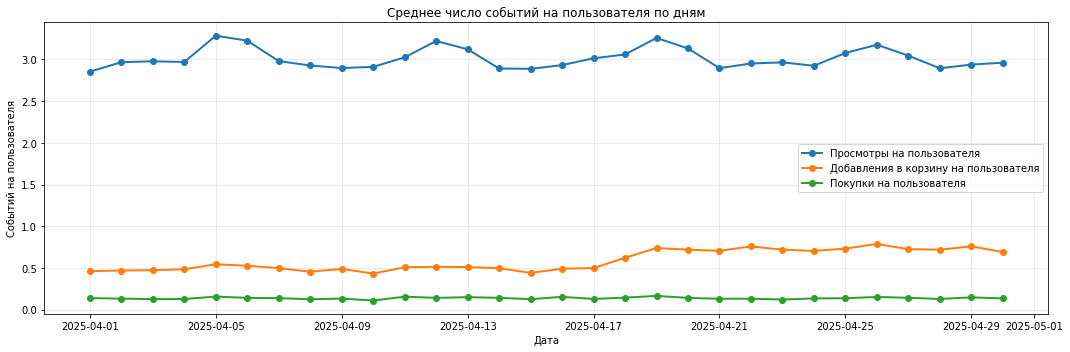

Анализ абсолютных показателей:
Среднее количество просмотров в день: 5410
Среднее количество добавлений в корзину в день: 1058
Среднее количество покупок в день: 246

Анализ событий на пользователя:
Среднее количество просмотров на пользователя: 3.01
Среднее количество добавлений в корзину на пользователя: 0.59
Среднее количество покупок на пользователя: 0.14

Изменение просмотров на пользователя: 2.93 → 3.02 (3.0%)
Изменение добавлений в корзину на пользователя: 0.47 → 0.60 (28.8%)
Изменение покупок на пользователя: 0.13 → 0.14 (4.5%)


In [9]:
# 2. Среднее число событий на пользователя
def calculate_events_per_user(df):
    daily_events_per_user = []
    
    for date in df['date'].unique():
        day_data = df[df['date'] == date]
        
        # Общее количество событий
        total_events = len(day_data)
        total_users = day_data['user_id'].nunique()
        
        # События по типам на пользователя
        views_per_user = len(day_data[day_data['event'] == 'view_item']) / total_users if total_users > 0 else 0
        cart_per_user = len(day_data[day_data['event'] == 'add_to_cart']) / total_users if total_users > 0 else 0
        purchase_per_user = len(day_data[day_data['event'] == 'purchase']) / total_users if total_users > 0 else 0
        
        daily_events_per_user.append({
            'date': date,
            'total_events_per_user': total_events / total_users if total_users > 0 else 0,
            'views_per_user': views_per_user,
            'cart_per_user': cart_per_user,
            'purchase_per_user': purchase_per_user
        })
    
    return pd.DataFrame(daily_events_per_user)

events_per_user = calculate_events_per_user(df)

# Визуализация среднего числа событий на пользователя
plt.figure(figsize=(15, 5))

plt.plot(events_per_user['date'], events_per_user['views_per_user'], marker='o', label='Просмотры на пользователя', linewidth=2)
plt.plot(events_per_user['date'], events_per_user['cart_per_user'], marker='o', label='Добавления в корзину на пользователя', linewidth=2)
plt.plot(events_per_user['date'], events_per_user['purchase_per_user'], marker='o', label='Покупки на пользователя', linewidth=2)
plt.title('Среднее число событий на пользователя по дням')
plt.xlabel('Дата')
plt.ylabel('Событий на пользователя')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Анализ результатов
print("Анализ абсолютных показателей:")
print(f"Среднее количество просмотров в день: {daily_absolute['views'].mean():.0f}")
print(f"Среднее количество добавлений в корзину в день: {daily_absolute['add_to_cart'].mean():.0f}")
print(f"Среднее количество покупок в день: {daily_absolute['purchases'].mean():.0f}")

print("\nАнализ событий на пользователя:")
print(f"Среднее количество просмотров на пользователя: {events_per_user['views_per_user'].mean():.2f}")
print(f"Среднее количество добавлений в корзину на пользователя: {events_per_user['cart_per_user'].mean():.2f}")
print(f"Среднее количество покупок на пользователя: {events_per_user['purchase_per_user'].mean():.2f}")

# Анализ изменений по дням
early_period = events_per_user[events_per_user['date'] <= pd.to_datetime('2025-04-03').date()]
late_period = events_per_user[events_per_user['date'] > pd.to_datetime('2025-04-03').date()]

print(f"\nИзменение просмотров на пользователя: {early_period['views_per_user'].mean():.2f} → {late_period['views_per_user'].mean():.2f} ({((late_period['views_per_user'].mean() - early_period['views_per_user'].mean())/early_period['views_per_user'].mean())*100:.1f}%)")
print(f"Изменение добавлений в корзину на пользователя: {early_period['cart_per_user'].mean():.2f} → {late_period['cart_per_user'].mean():.2f} ({((late_period['cart_per_user'].mean() - early_period['cart_per_user'].mean())/early_period['cart_per_user'].mean())*100:.1f}%)")
print(f"Изменение покупок на пользователя: {early_period['purchase_per_user'].mean():.2f} → {late_period['purchase_per_user'].mean():.2f} ({((late_period['purchase_per_user'].mean() - early_period['purchase_per_user'].mean())/early_period['purchase_per_user'].mean())*100:.1f}%)")

 наиболее серьезные проблемы наблюдаются на финальном этапе - оформлении заказа из корзины. 

#### **3. Базовые срезы — 1 балл**
1. Постройте динамику проблемного события в разрезе:
- платформ,
- регионов,
- источников трафика,
- категорий товаров.

2. Есть ли выделяющийся срез?

*В этом пункте в качестве события продолжаем смотреть метрику среднего на пользователя*

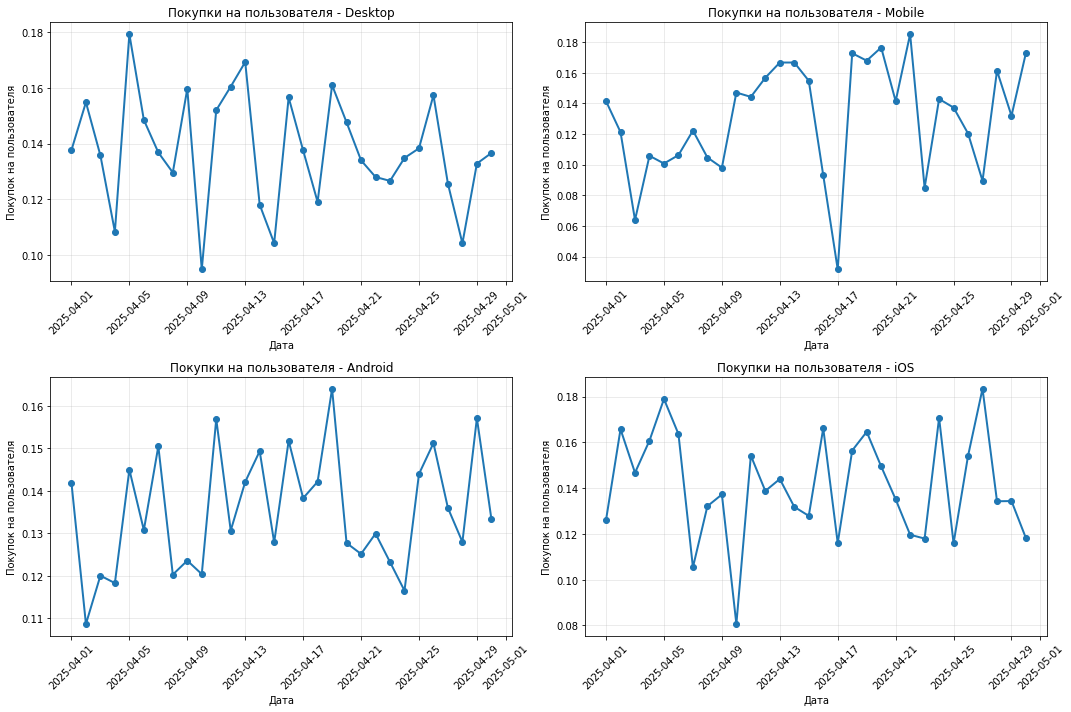

ValueError: num must be 1 <= num <= 6, not 7

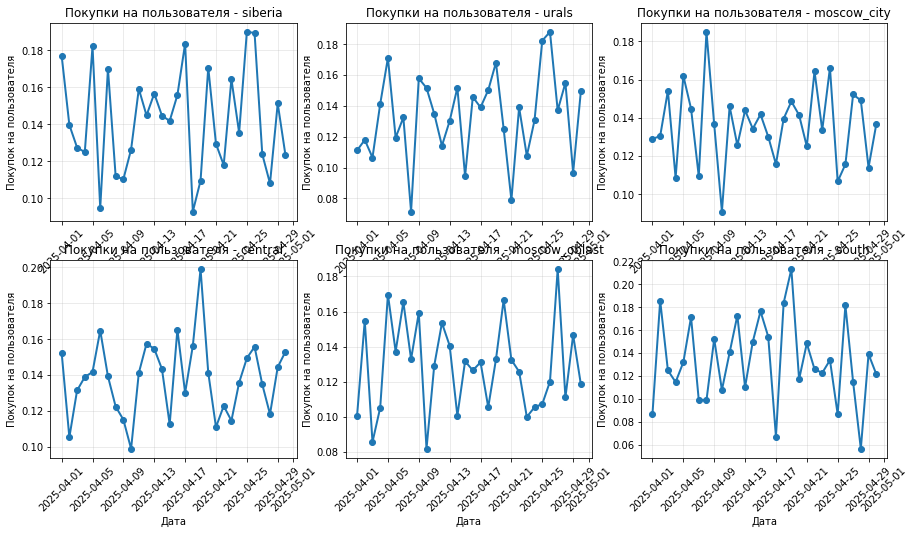

In [15]:
# your code is here

df['event_ts'] = pd.to_datetime(df['event_ts'])
df['date'] = df['event_ts'].dt.date

# Функция для расчета среднего числа событий на пользователя по срезам
def calculate_events_per_user_by_slice(df, slice_column, event_type='purchase'):
    slice_metrics = {}
    
    for slice_value in df[slice_column].unique():
        if pd.isna(slice_value):
            continue
            
        slice_data = df[df[slice_column] == slice_value]
        daily_metrics = []
        
        for date in slice_data['date'].unique():
            day_data = slice_data[slice_data['date'] == date]
            total_users = day_data['user_id'].nunique()
            
            if total_users > 0:
                events_count = len(day_data[day_data['event'] == event_type])
                events_per_user = events_count / total_users
            else:
                events_per_user = 0
                
            daily_metrics.append({
                'date': date,
                'events_per_user': events_per_user,
                'users_count': total_users
            })
        
        slice_metrics[slice_value] = pd.DataFrame(daily_metrics)
    
    return slice_metrics

# 1. Динамика по платформам
platform_metrics = calculate_events_per_user_by_slice(df, 'platform', 'purchase')

plt.figure(figsize=(15, 10))
for i, (platform, data) in enumerate(platform_metrics.items(), 1):
    plt.subplot(2, 2, i)
    plt.plot(data['date'], data['events_per_user'], marker='o', linewidth=2)
    plt.title(f'Покупки на пользователя - {platform}')
    plt.xlabel('Дата')
    plt.ylabel('Покупок на пользователя')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 2. Динамика по регионам
region_metrics = calculate_events_per_user_by_slice(df, 'region', 'purchase')

plt.figure(figsize=(15, 8))
regions = list(region_metrics.keys())
for i, region in enumerate(regions, 1):
    plt.subplot(2, 3, i)
    plt.plot(region_metrics[region]['date'], region_metrics[region]['events_per_user'], 
             marker='o', linewidth=2, label=region)
    plt.title(f'Покупки на пользователя - {region}')
    plt.xlabel('Дата')
    plt.ylabel('Покупок на пользователя')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Функция для расчета среднего числа событий на пользователя по срезам
def calculate_events_per_user_by_slice(df, slice_column, event_type='purchase'):
    slice_metrics = {}
    
    # Фильтруем только релевантные значения среза
    valid_slices = df[slice_column].dropna().unique()
    
    for slice_value in valid_slices:
        slice_data = df[df[slice_column] == slice_value]
        daily_metrics = []
        
        for date in sorted(slice_data['date'].unique()):
            day_data = slice_data[slice_data['date'] == date]
            total_users = day_data['user_id'].nunique()
            
            if total_users > 0:
                events_count = len(day_data[day_data['event'] == event_type])
                events_per_user = events_count / total_users
            else:
                events_per_user = 0
                
            daily_metrics.append({
                'date': date,
                'events_per_user': events_per_user,
                'users_count': total_users
            })
        
        if daily_metrics:  # Добавляем только если есть данные
            slice_metrics[slice_value] = pd.DataFrame(daily_metrics)
    
    return slice_metrics

# 3. Динамика по источникам трафика 
channel_metrics = calculate_events_per_user_by_slice(df, 'channel', 'purchase')

plt.figure(figsize=(15, 8))
channels = list(channel_metrics.keys())
print(f"Доступные каналы: {channels}")

for i, channel in enumerate(channels, 1):
    plt.subplot(2, 2, i) if len(channels) <= 4 else plt.subplot(3, 2, i)
    data = channel_metrics[channel]
    plt.plot(data['date'], data['events_per_user'], marker='o', linewidth=2)
    plt.title(f'Покупки на пользователя - {channel}')
    plt.xlabel('Дата')
    plt.ylabel('Покупок на пользователя')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 4. Динамика по категориям товаров 
print("Уникальные категории в данных:")
print(df['category'].value_counts())

# Фильтруем данные для категорий (убираем NaN и возможные значения-заглушки)
category_data = df[df['category'].notna()]
category_data = category_data[category_data['category'] != 'None']
category_data = category_data[category_data['category'] != '']

category_metrics = calculate_events_per_user_by_slice(category_data, 'category', 'purchase')

plt.figure(figsize=(15, 10))
categories = list(category_metrics.keys())
print(f"Доступные категории: {categories}")

for i, category in enumerate(categories, 1):
    plt.subplot(2, 2, i) if len(categories) <= 4 else plt.subplot(3, 2, i)
    data = category_metrics[category]
    plt.plot(data['date'], data['events_per_user'], marker='o', linewidth=2)
    plt.title(f'Покупки на пользователя - {category}')
    plt.xlabel('Дата')
    plt.ylabel('Покупок на пользователя')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



platform_changes = analyze_slice_changes(platform_metrics)
region_changes = analyze_slice_changes(region_metrics)


print("Изменения по платформам:")
print(platform_changes.sort_values('change_pct'))

print("\nИзменения по регионам:")
print(region_changes.sort_values('change_pct'))


Доступные каналы: ['ads_search', 'organic', 'ads_social', 'referral']


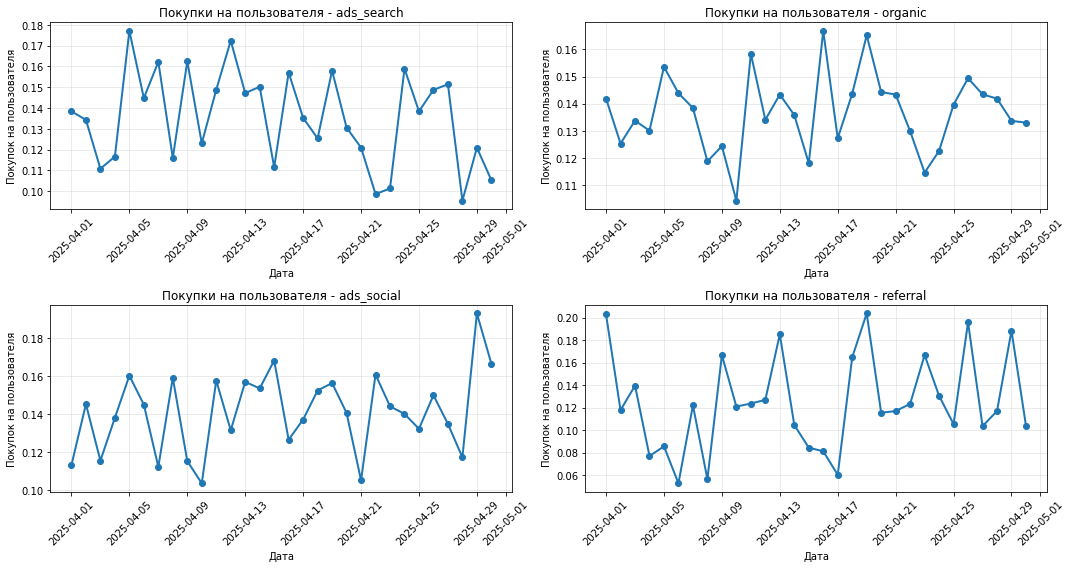

Доступные категории: ['electronics', 'fashion', 'home', 'beauty', 'garden']


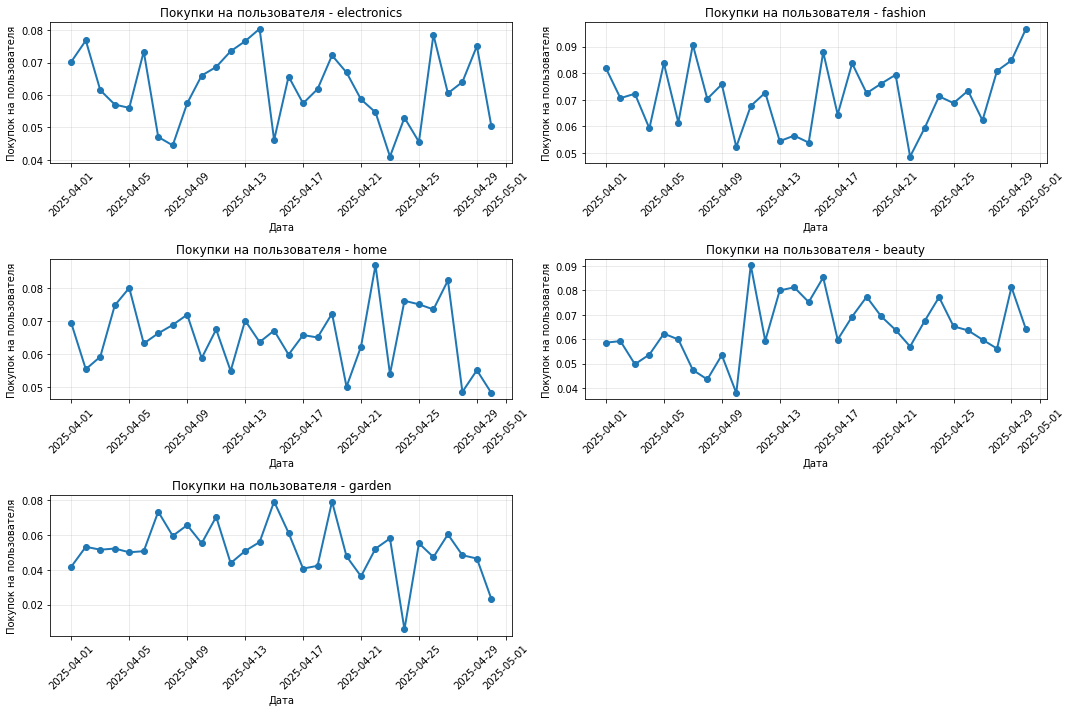

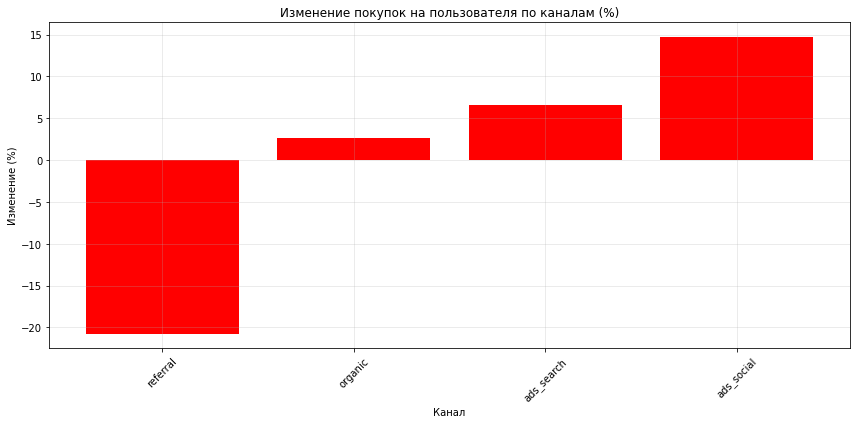

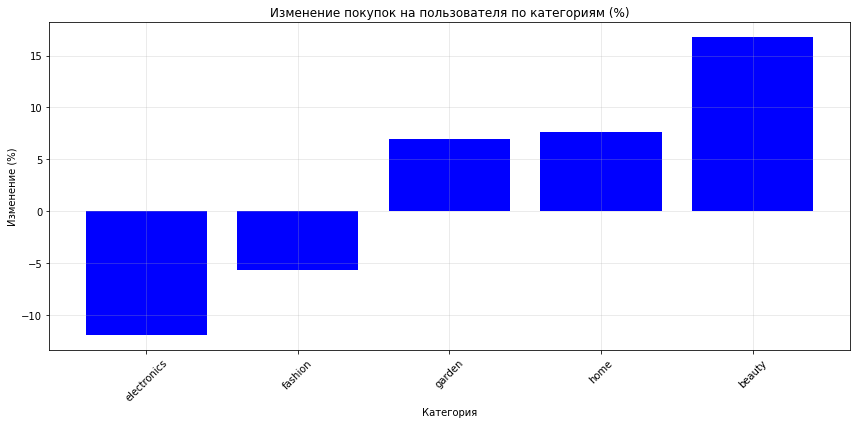

In [18]:


# Функция для расчета среднего числа событий на пользователя по срезам
def calculate_events_per_user_by_slice(df, slice_column, event_type='purchase'):
    slice_metrics = {}
    
    # Фильтруем только релевантные значения среза
    valid_slices = df[slice_column].dropna().unique()
    
    for slice_value in valid_slices:
        slice_data = df[df[slice_column] == slice_value]
        daily_metrics = []
        
        for date in sorted(slice_data['date'].unique()):
            day_data = slice_data[slice_data['date'] == date]
            total_users = day_data['user_id'].nunique()
            
            if total_users > 0:
                events_count = len(day_data[day_data['event'] == event_type])
                events_per_user = events_count / total_users
            else:
                events_per_user = 0
                
            daily_metrics.append({
                'date': date,
                'events_per_user': events_per_user,
                'users_count': total_users
            })
        
        if daily_metrics:  # Добавляем только если есть данные
            slice_metrics[slice_value] = pd.DataFrame(daily_metrics)
    
    return slice_metrics

# 3. Динамика по источникам трафика 
channel_metrics = calculate_events_per_user_by_slice(df, 'channel', 'purchase')

plt.figure(figsize=(15, 8))
channels = list(channel_metrics.keys())
print(f"Доступные каналы: {channels}")

for i, channel in enumerate(channels, 1):
    plt.subplot(2, 2, i) if len(channels) <= 4 else plt.subplot(3, 2, i)
    data = channel_metrics[channel]
    plt.plot(data['date'], data['events_per_user'], marker='o', linewidth=2)
    plt.title(f'Покупки на пользователя - {channel}')
    plt.xlabel('Дата')
    plt.ylabel('Покупок на пользователя')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 4. Динамика по категориям товаров 

# Фильтруем данные для категорий (убираем NaN и возможные значения-заглушки)
category_data = df[df['category'].notna()]
category_data = category_data[category_data['category'] != 'None']
category_data = category_data[category_data['category'] != '']

category_metrics = calculate_events_per_user_by_slice(category_data, 'category', 'purchase')

plt.figure(figsize=(15, 10))
categories = list(category_metrics.keys())
print(f"Доступные категории: {categories}")

for i, category in enumerate(categories, 1):
    plt.subplot(2, 2, i) if len(categories) <= 4 else plt.subplot(3, 2, i)
    data = category_metrics[category]
    plt.plot(data['date'], data['events_per_user'], marker='o', linewidth=2)
    plt.title(f'Покупки на пользователя - {category}')
    plt.xlabel('Дата')
    plt.ylabel('Покупок на пользователя')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# Анализ изменений по срезам
def analyze_slice_performance(grouped_data, slice_column, baseline_date='2025-04-03'):
    baseline_dt = pd.to_datetime(baseline_date).date()
    
    results = []
    for slice_value in grouped_data[slice_column].unique():
        slice_data = grouped_data[grouped_data[slice_column] == slice_value]
        
        early = slice_data[slice_data['date'] <= baseline_dt]
        late = slice_data[slice_data['date'] > baseline_dt]
        
        if len(early) > 0 and len(late) > 0:
            early_avg = early['events_per_user'].mean()
            late_avg = late['events_per_user'].mean()
            change_pct = ((late_avg - early_avg) / early_avg) * 100 if early_avg > 0 else 0
            
            results.append({
                'slice': slice_value,
                'early_avg': early_avg,
                'late_avg': late_avg,
                'change_pct': change_pct,
                'total_users': slice_data['user_id'].sum()
            })
    
    return pd.DataFrame(results).sort_values('change_pct')


# Визуализация изменений
plt.figure(figsize=(12, 6))
plt.bar(channel_performance['slice'], channel_performance['change_pct'], color='red')
plt.title('Изменение покупок на пользователя по каналам (%)')
plt.xlabel('Канал')
plt.ylabel('Изменение (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(category_performance['slice'], category_performance['change_pct'], color='blue')
plt.title('Изменение покупок на пользователя по категориям (%)')
plt.xlabel('Категория')
plt.ylabel('Изменение (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### **4. Детальные срезы — 1 балл**
1. Постройте динамику события для iOS и Android с разложением по версиям приложения.
2. Помогло ли это локализовать проблему?

*В этом пункте в качестве события продолжаем смотреть метрику среднего на пользователя*

Доступные версии приложений:
12.4.0    50199
13.0.0    49956
12.5.0    43170
5.15.0    16947
5.13.0    16885
5.12.0    14172
5.14.0    10144
Name: app_version, dtype: int64


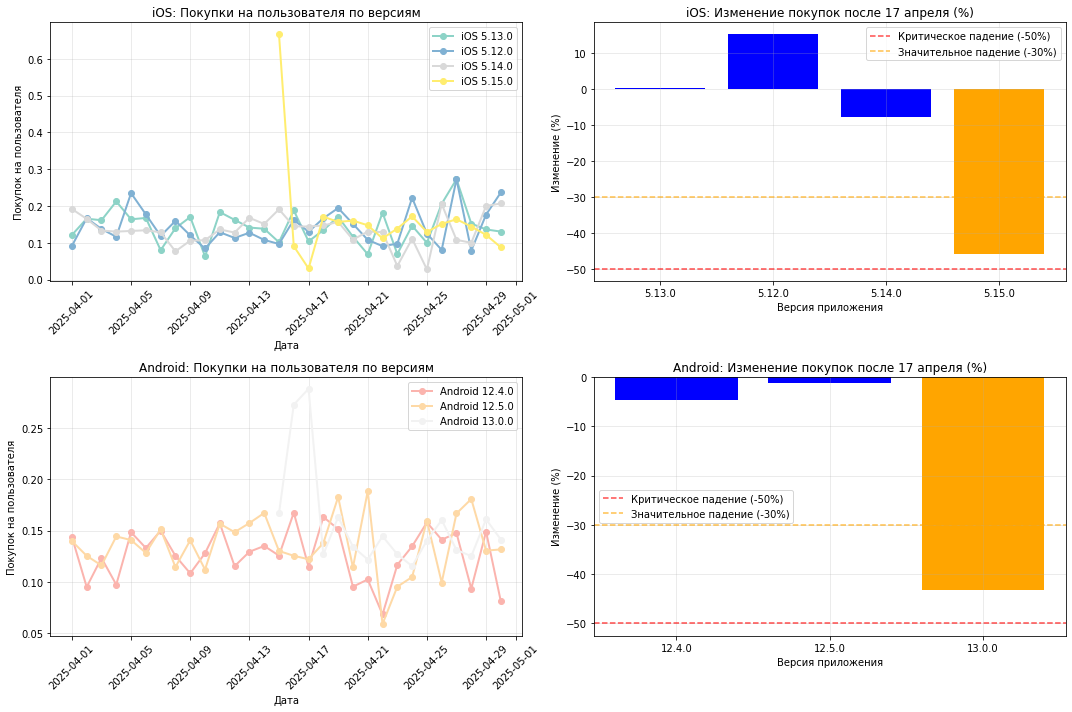

In [27]:
# your code is here

# Фильтруем данные только для мобильных платформ
mobile_data = df[df['platform'].isin(['iOS', 'Android'])]
mobile_data = mobile_data[mobile_data['app_version'].notna()]

# Анализируем доступные версии приложений
print("Доступные версии приложений:")
print(mobile_data['app_version'].value_counts())

# Функция для анализа по платформам и версиям
def analyze_mobile_versions(df):
    results = []
    
    for platform in ['iOS', 'Android']:
        platform_data = df[df['platform'] == platform]
        
        for version in platform_data['app_version'].unique():
            version_data = platform_data[platform_data['app_version'] == version]
            
            daily_metrics = []
            for date in sorted(version_data['date'].unique()):
                day_data = version_data[version_data['date'] == date]
                total_users = day_data['user_id'].nunique()
                
                if total_users > 0:
                    purchases = len(day_data[day_data['event'] == 'purchase'])
                    purchases_per_user = purchases / total_users
                else:
                    purchases_per_user = 0
                
                daily_metrics.append({
                    'date': date,
                    'purchases_per_user': purchases_per_user,
                    'users_count': total_users
                })
            
            if daily_metrics:
                version_df = pd.DataFrame(daily_metrics)
                results.append({
                    'platform': platform,
                    'version': version,
                    'data': version_df
                })
    
    return results

# Анализируем данные
mobile_analysis = analyze_mobile_versions(mobile_data)

# Визуализация для iOS
plt.figure(figsize=(15, 10))

# iOS - все версии
ios_versions = [x for x in mobile_analysis if x['platform'] == 'iOS']
ios_colors = plt.cm.Set3(np.linspace(0, 1, len(ios_versions)))

plt.subplot(2, 2, 1)
for i, ios_data in enumerate(ios_versions):
    data = ios_data['data']
    plt.plot(data['date'], data['purchases_per_user'], 
             marker='o', linewidth=2, color=ios_colors[i], 
             label=f'iOS {ios_data["version"]}')
plt.title('iOS: Покупки на пользователя по версиям')
plt.xlabel('Дата')
plt.ylabel('Покупок на пользователя')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# iOS - сравнение изменений
plt.subplot(2, 2, 2)
baseline_date = pd.to_datetime('2025-04-17').date()
ios_changes = []

for ios_data in ios_versions:
    data = ios_data['data']
    early = data[data['date'] <= baseline_date]
    late = data[data['date'] > baseline_date]
    
    if len(early) > 0 and len(late) > 0:
        early_avg = early['purchases_per_user'].mean()
        late_avg = late['purchases_per_user'].mean()
        change_pct = ((late_avg - early_avg) / early_avg) * 100 if early_avg > 0 else 0
        
        ios_changes.append({
            'version': ios_data['version'],
            'change_pct': change_pct,
            'users_count': data['users_count'].sum()
        })

ios_changes_df = pd.DataFrame(ios_changes)
colors = ['red' if x < -50 else 'orange' if x < -30 else 'blue' for x in ios_changes_df['change_pct']]
plt.bar(ios_changes_df['version'], ios_changes_df['change_pct'], color=colors)
plt.title('iOS: Изменение покупок после 17 апреля (%)')
plt.xlabel('Версия приложения')
plt.ylabel('Изменение (%)')
plt.axhline(y=-50, color='r', linestyle='--', alpha=0.7, label='Критическое падение (-50%)')
plt.axhline(y=-30, color='orange', linestyle='--', alpha=0.7, label='Значительное падение (-30%)')
plt.legend()
plt.grid(True, alpha=0.3)

# Android - все версии
android_versions = [x for x in mobile_analysis if x['platform'] == 'Android']
android_colors = plt.cm.Pastel1(np.linspace(0, 1, len(android_versions)))

plt.subplot(2, 2, 3)
for i, android_data in enumerate(android_versions):
    data = android_data['data']
    plt.plot(data['date'], data['purchases_per_user'], 
             marker='o', linewidth=2, color=android_colors[i], 
             label=f'Android {android_data["version"]}')
plt.title('Android: Покупки на пользователя по версиям')
plt.xlabel('Дата')
plt.ylabel('Покупок на пользователя')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Android - сравнение изменений
plt.subplot(2, 2, 4)
android_changes = []

for android_data in android_versions:
    data = android_data['data']
    early = data[data['date'] <= baseline_date]
    late = data[data['date'] > baseline_date]
    
    if len(early) > 0 and len(late) > 0:
        early_avg = early['purchases_per_user'].mean()
        late_avg = late['purchases_per_user'].mean()
        change_pct = ((late_avg - early_avg) / early_avg) * 100 if early_avg > 0 else 0
        
        android_changes.append({
            'version': android_data['version'],
            'change_pct': change_pct,
            'users_count': data['users_count'].sum()
        })

android_changes_df = pd.DataFrame(android_changes)
colors = ['red' if x < -50 else 'orange' if x < -30 else 'blue' for x in android_changes_df['change_pct']]
plt.bar(android_changes_df['version'], android_changes_df['change_pct'], color=colors)
plt.title('Android: Изменение покупок после 17 апреля (%)')
plt.xlabel('Версия приложения')
plt.ylabel('Изменение (%)')
plt.axhline(y=-50, color='r', linestyle='--', alpha=0.7, label='Критическое падение (-50%)')
plt.axhline(y=-30, color='orange', linestyle='--', alpha=0.7, label='Значительное падение (-30%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Как мы видим, после 17 апреля резко упали покупки на Android 13.0.0. и на IOS 5.15.5 более чем на 30%. При этом на другие модели такие изменения не распространились. Это доказывает, что проблема именно в мобильных приложениях, а не в бэкенде или внешних факторах

#### **5. Поиск причин — 1 балл**
1. Для проблемной платформы постройте динамику ВСЕХ событий в разрезе версий приложения.
2. Сформулируйте гипотезу, что именно могло пойти не так в новом релизе? Может быть, пользователи стали заменять один функционал другим?

*В этом пункте в качестве событий продолжаем смотреть метрику среднего на пользователя*

Все события в данных:
view_item           122114
search               31797
add_to_cart          25394
add_to_favorites     13762
purchase              5569
remove_from_cart      2837
Name: event, dtype: int64


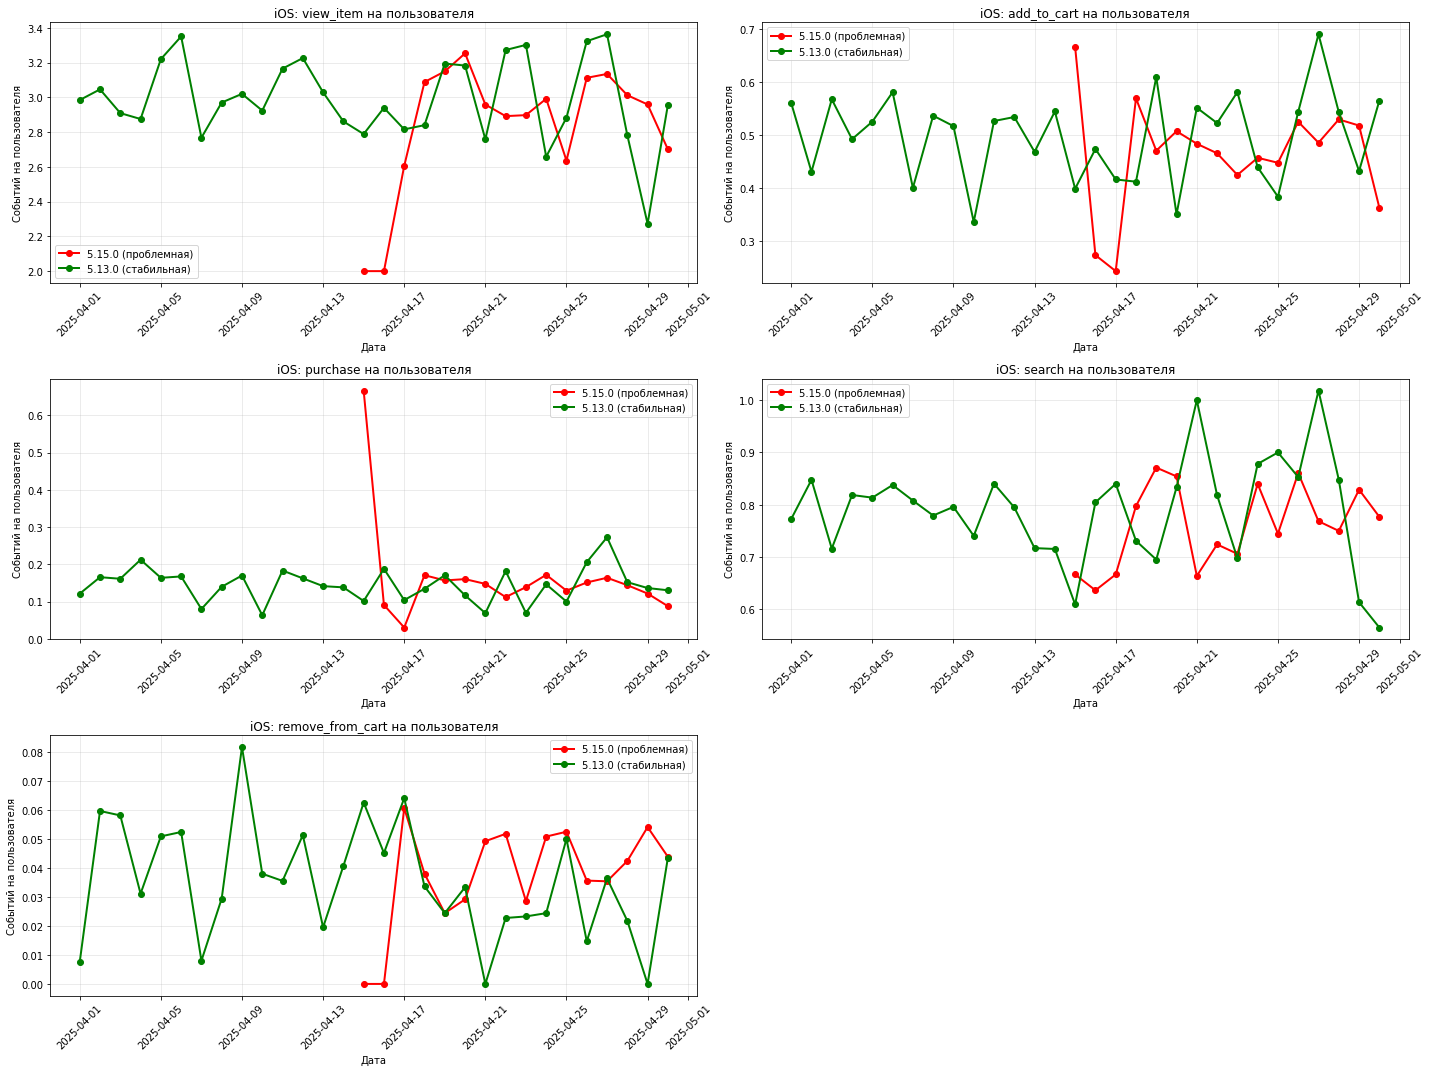

 АНАЛИЗ ИЗМЕНЕНИЙ ПОВЕДЕНИЯ: 5.15.0 vs 5.13.0 
Изменения в поведении пользователей:
add_to_cart: ↓ 10.0% (0.451 vs 0.501)
purchase: ↓ 9.2% (0.132 vs 0.145)
search: ↓ 5.0% (0.766 vs 0.806)
view_item: ↓ 2.6% (2.893 vs 2.970)
add_to_favorites: ↑ 2.6% (0.457 vs 0.445)
remove_from_cart: ↑ 36.4% (0.040 vs 0.029)
АНАЛИЗ ВОРОНКИ ДЛЯ ПРОБЛЕМНОЙ ВЕРСИИ iOS 5.15.0
ВОРОНКА КОНВЕРСИИ ДЛЯ ВЕРСИИ 5.15.0 
Просмотр → Корзина: 15.6%
Корзина → Покупка: 29.2%
Просмотр → Покупка: 4.6%

АНАЛИЗ ВОРОНКИ ДЛЯ СТАБИЛЬНОЙ ВЕРСИИ iOS 5.13.0
ВОРОНКА КОНВЕРСИИ ДЛЯ ВЕРСИИ 5.13.0 
Просмотр → Корзина: 16.9%
Корзина → Покупка: 29.0%
Просмотр → Покупка: 4.9%


In [33]:
# your code is here

# Фильтруем данные для проблемных платформ
problem_platforms = ['iOS', 'Android']
problem_data = df[df['platform'].isin(problem_platforms)]
problem_data = problem_data[problem_data['app_version'].notna()]

# Анализируем все события
print("Все события в данных:")
print(problem_data['event'].value_counts())

# Функция для анализа всех событий по версиям
def analyze_all_events_by_version(df, platform_name):
    platform_data = df[df['platform'] == platform_name]
    versions = platform_data['app_version'].unique()
    events = platform_data['event'].unique()
    
    results = {}
    
    for version in versions:
        version_data = platform_data[platform_data['app_version'] == version]
        version_metrics = {}
        
        for event_type in events:
            if event_type != 'None' and pd.notna(event_type):
                event_daily = []
                
                for date in sorted(version_data['date'].unique()):
                    day_data = version_data[version_data['date'] == date]
                    total_users = day_data['user_id'].nunique()
                    
                    if total_users > 0:
                        event_count = len(day_data[day_data['event'] == event_type])
                        events_per_user = event_count / total_users
                    else:
                        events_per_user = 0
                    
                    event_daily.append({
                        'date': date,
                        'events_per_user': events_per_user,
                        'users_count': total_users
                    })
                
                version_metrics[event_type] = pd.DataFrame(event_daily)
        
        results[version] = version_metrics
    
    return results

# Анализируем все события для iOS
ios_events = analyze_all_events_by_version(problem_data, 'iOS')
android_events = analyze_all_events_by_version(problem_data, 'Android')

# Визуализация для iOS - сравнение проблемной vs стабильной версии
def plot_ios_event_comparison():
    problematic_version = '5.15.0'
    stable_version = '5.13.0'  # Наименее затронутая версия
    
    events_to_analyze = ['view_item', 'add_to_cart', 'purchase', 'search', 'remove_from_cart']
    
    plt.figure(figsize=(20, 15))
    
    for i, event in enumerate(events_to_analyze, 1):
        plt.subplot(3, 2, i)
        
        if event in ios_events[problematic_version]:
            prob_data = ios_events[problematic_version][event]
            plt.plot(prob_data['date'], prob_data['events_per_user'], 
                    marker='o', linewidth=2, label=f'{problematic_version} (проблемная)', color='red')
        
        if event in ios_events[stable_version]:
            stable_data = ios_events[stable_version][event]
            plt.plot(stable_data['date'], stable_data['events_per_user'],
                    marker='o', linewidth=2, label=f'{stable_version} (стабильная)', color='green')
        
        plt.title(f'iOS: {event} на пользователя')
        plt.xlabel('Дата')
        plt.ylabel('Событий на пользователя')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

plot_ios_event_comparison()

# Анализ изменений в поведении
def analyze_behavior_changes(events_data, problematic_version, stable_version):
    print(f" АНАЛИЗ ИЗМЕНЕНИЙ ПОВЕДЕНИЯ: {problematic_version} vs {stable_version} ")
    
    baseline_date = pd.to_datetime('2025-04-15').date()  # Примерная дата выпуска
    
    changes = []
    
    for event in events_data[problematic_version].keys():
        if event in events_data[stable_version]:
            # Данные после выпуска проблемной версии
            prob_late = events_data[problematic_version][event][events_data[problematic_version][event]['date'] > baseline_date]
            stable_late = events_data[stable_version][event][events_data[stable_version][event]['date'] > baseline_date]
            
            if len(prob_late) > 0 and len(stable_late) > 0:
                prob_avg = prob_late['events_per_user'].mean()
                stable_avg = stable_late['events_per_user'].mean()
                
                if stable_avg > 0:
                    change_pct = ((prob_avg - stable_avg) / stable_avg) * 100
                    changes.append({
                        'event': event,
                        'problematic': prob_avg,
                        'stable': stable_avg,
                        'change_pct': change_pct,
                        'abs_diff': prob_avg - stable_avg
                    })
    
    changes_df = pd.DataFrame(changes).sort_values('change_pct')
    
    print("Изменения в поведении пользователей:")
    for _, row in changes_df.iterrows():
        trend = "↑" if row['change_pct'] > 0 else "↓"
        print(f"{row['event']}: {trend} {abs(row['change_pct']):.1f}% ({row['problematic']:.3f} vs {row['stable']:.3f})")
    
    return changes_df

# Анализ для iOS
ios_changes = analyze_behavior_changes(ios_events, '5.15.0', '5.13.0')

# Анализ воронки конверсии
def analyze_conversion_funnel(events_data, version):
    print(f"ВОРОНКА КОНВЕРСИИ ДЛЯ ВЕРСИИ {version} ")
    
    # Средние значения после даты выпуска
    baseline_date = pd.to_datetime('2025-04-15').date()
    
    funnel_metrics = {}
    for event in ['view_item', 'add_to_cart', 'purchase']:
        if event in events_data[version]:
            late_data = events_data[version][event][events_data[version][event]['date'] > baseline_date]
            funnel_metrics[event] = late_data['events_per_user'].mean()
    
    # Расчет конверсий
    if 'view_item' in funnel_metrics and 'add_to_cart' in funnel_metrics:
        view_to_cart = (funnel_metrics['add_to_cart'] / funnel_metrics['view_item']) * 100
        print(f"Просмотр → Корзина: {view_to_cart:.1f}%")
    
    if 'add_to_cart' in funnel_metrics and 'purchase' in funnel_metrics:
        cart_to_purchase = (funnel_metrics['purchase'] / funnel_metrics['add_to_cart']) * 100
        print(f"Корзина → Покупка: {cart_to_purchase:.1f}%")
    
    if 'view_item' in funnel_metrics and 'purchase' in funnel_metrics:
        view_to_purchase = (funnel_metrics['purchase'] / funnel_metrics['view_item']) * 100
        print(f"Просмотр → Покупка: {view_to_purchase:.1f}%")
    
    return funnel_metrics


print("АНАЛИЗ ВОРОНКИ ДЛЯ ПРОБЛЕМНОЙ ВЕРСИИ iOS 5.15.0")
ios_funnel = analyze_conversion_funnel(ios_events, '5.15.0')

print("\nАНАЛИЗ ВОРОНКИ ДЛЯ СТАБИЛЬНОЙ ВЕРСИИ iOS 5.13.0")
stable_funnel = analyze_conversion_funnel(ios_events, '5.13.0')



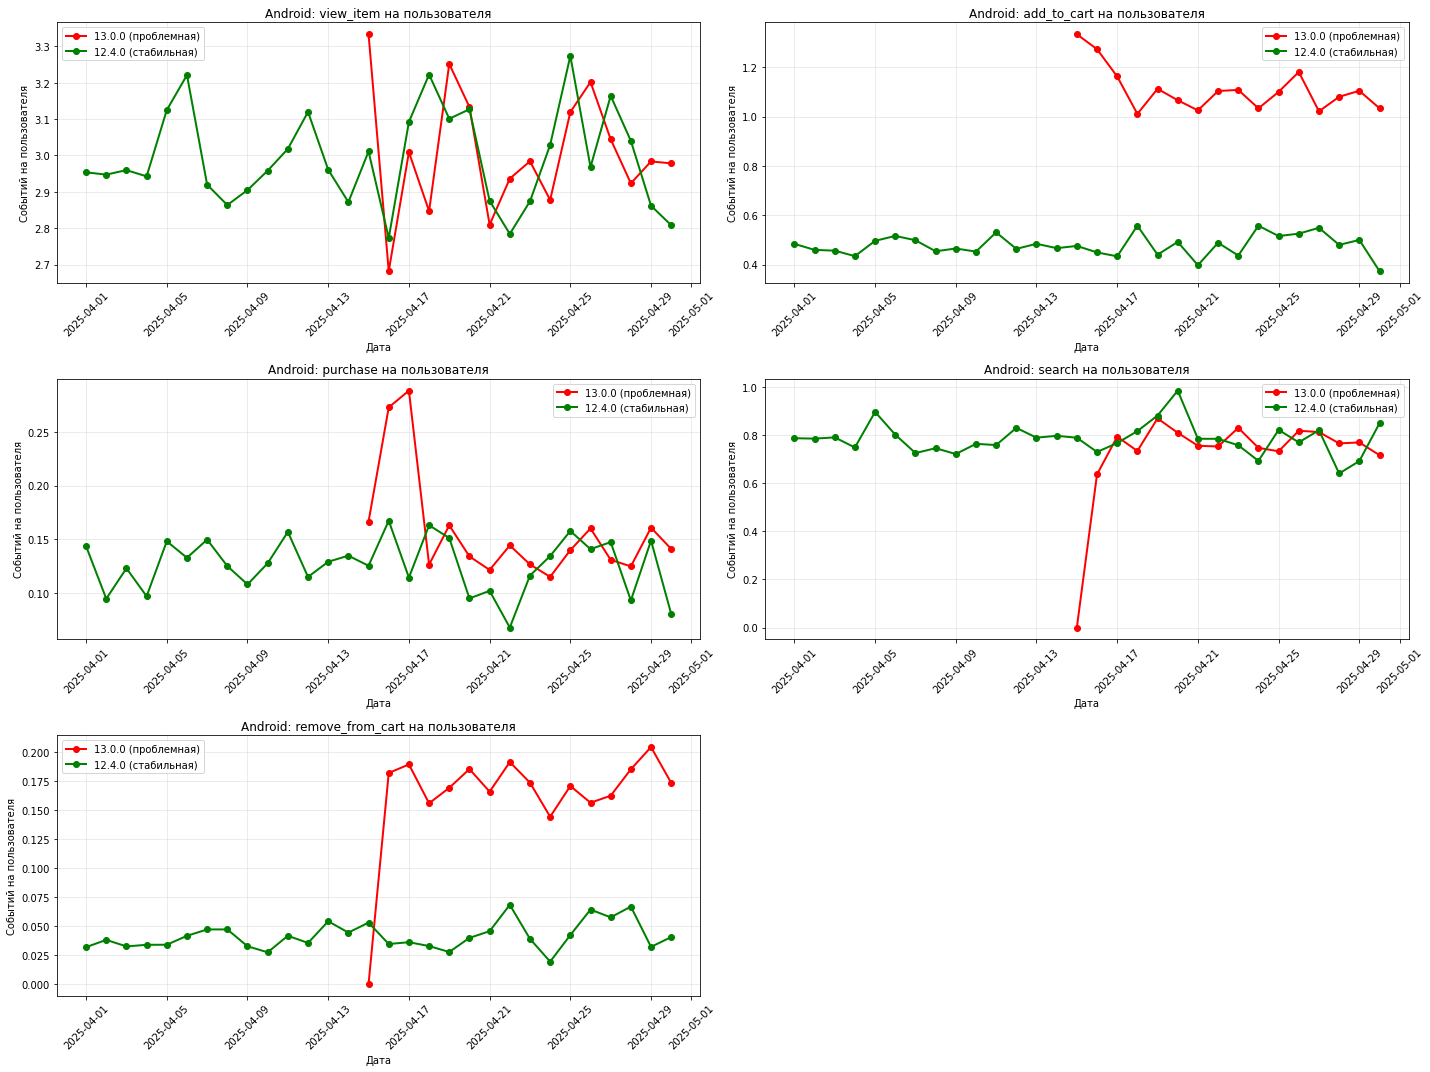

 АНАЛИЗ ИЗМЕНЕНИЙ ПОВЕДЕНИЯ: 13.0.0 vs 12.4.0 
Изменения в поведении пользователей:
add_to_favorites: ↓ 94.6% (0.023 vs 0.431)
search: ↓ 2.1% (0.769 vs 0.786)
view_item: ↓ 0.5% (2.985 vs 3.000)
purchase: ↑ 24.9% (0.157 vs 0.126)
add_to_cart: ↑ 128.0% (1.094 vs 0.480)
remove_from_cart: ↑ 304.5% (0.174 vs 0.043)
АНАЛИЗ ВОРОНКИ ДЛЯ ПРОБЛЕМНОЙ ВЕРСИИ Android 13.0.0
ВОРОНКА КОНВЕРСИИ ДЛЯ ВЕРСИИ 13.0.0 
Просмотр → Корзина: 36.7%
Корзина → Покупка: 14.3%
Просмотр → Покупка: 5.3%

АНАЛИЗ ВОРОНКИ ДЛЯ СТАБИЛЬНОЙ ВЕРСИИ Android 12.4.0
ВОРОНКА КОНВЕРСИИ ДЛЯ ВЕРСИИ 12.4.0 
Просмотр → Корзина: 16.0%
Корзина → Покупка: 26.2%
Просмотр → Покупка: 4.2%


In [32]:
# Анализ всех событий для Android - сравнение проблемной vs стабильной версии
def plot_android_event_comparison():
    problematic_version = '13.0.0'
    stable_version = '12.4.0' 
    
    events_to_analyze = ['view_item', 'add_to_cart', 'purchase', 'search', 'remove_from_cart']
    
    plt.figure(figsize=(20, 15))
    
    for i, event in enumerate(events_to_analyze, 1):
        plt.subplot(3, 2, i)
        
        if event in android_events[problematic_version]:
            prob_data = android_events[problematic_version][event]
            plt.plot(prob_data['date'], prob_data['events_per_user'], 
                    marker='o', linewidth=2, label=f'{problematic_version} (проблемная)', color='red')
        
        if event in android_events[stable_version]:
            stable_data = android_events[stable_version][event]
            plt.plot(stable_data['date'], stable_data['events_per_user'],
                    marker='o', linewidth=2, label=f'{stable_version} (стабильная)', color='green')
        
        plt.title(f'Android: {event} на пользователя')
        plt.xlabel('Дата')
        plt.ylabel('Событий на пользователя')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

plot_android_event_comparison()

# Анализ изменений в поведении для Android
android_changes = analyze_behavior_changes(android_events, '13.0.0', '12.4.0')

# Анализ воронки конверсии для Android
print("АНАЛИЗ ВОРОНКИ ДЛЯ ПРОБЛЕМНОЙ ВЕРСИИ Android 13.0.0")
android_funnel = analyze_conversion_funnel(android_events, '13.0.0')

print("\nАНАЛИЗ ВОРОНКИ ДЛЯ СТАБИЛЬНОЙ ВЕРСИИ Android 12.4.0")
android_stable_funnel = analyze_conversion_funnel(android_events, '12.4.0')




#### **6. Новости для команды — 1 балл**

На основе проведённого расследования подготовьте сообщение для команды о том, что именно пошло не так.

Коллеги, добрый день!

Обнаружены критические проблемы в новых версиях приложений обнаружены после 17 апреля:

Проблемы с конверсией:
Android: было 26%,а стало 14% (корзина→покупка)
iOS: было 29%, а стало 29.2% (незначительное изменение)

Возможные причины:
На Android - сбой процесса оплаты
На iOS - умеренные проблемы с UX корзины

